In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
import torch
from esm.models.esm3 import ESM3
from esm.sdk.api import ESM3InferenceClient, ESMProtein, GenerationConfig
from esm.tokenization import get_model_tokenizers
from esm.utils.constants import esm3 as ESM_CONSTANTS
from esm.utils.decoding import decode_structure
from esm.utils.encoding import tokenize_structure
from esm.utils.generation import _stack_protein_tensors
from esm.utils.structure.protein_chain import ProteinChain
from loguru import logger

/home/ssledzieski/miniforge3/envs/pytorch/lib/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
import mdtraj as md

from rocketshp import config
from rocketshp.plot import display_trajectory

2024-11-11 15:45:05.303 | INFO     | rocketshp.config:<module>:11 - PROJ_ROOT path is: /mnt/home/ssledzieski/Projects/rocketshp


In [4]:
# This will download the model weights and instantiate the model on your machine.
model: ESM3InferenceClient = ESM3.from_pretrained("esm3-open").to("cuda") # or "cpu"

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/ssledzieski/miniforge3/envs/pytorch/lib/python3.11/site-packages/esm/pretrained.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [5]:
test_structure_path = "/mnt/ceph/users/protfold/PDB_mirror/pdb/u8/pdb5u8e.ent.gz"

import gzip
from io import StringIO

with gzip.GzipFile(test_structure_path, 'r') as f:
    content = f.read().decode('utf-8')
    struct_buffer = StringIO(content)
    test_structure = ESMProtein.from_pdb(struct_buffer)
    struct_buffer.close()

In [5]:
from esm.pretrained import ESM3_structure_decoder_v0, ESM3_structure_encoder_v0

sencoder = ESM3_structure_encoder_v0().cuda()
sdecoder = ESM3_structure_decoder_v0().cuda()

/home/ssledzieski/miniforge3/envs/pytorch/lib/python3.11/site-packages/esm/pretrained.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/ssl

In [6]:
coordinates = test_structure.coordinates
ref_sequence = test_structure.sequence
struct_encoder = model.get_structure_encoder().eval()
tokenizers = get_model_tokenizers("esm3-open")

with torch.inference_mode():
    (coordinates, plddt, struct_tokens) = tokenize_structure(coordinates, structure_encoder=struct_encoder, structure_tokenizer=tokenizers.structure, reference_sequence=ref_sequence)
logger.info(f"Coordinates shape: {coordinates.shape}")
logger.info(f"Sequence length: {len(ref_sequence)}")
logger.info(f"Structure tokens shape: {struct_tokens.shape}")

/home/ssledzieski/miniforge3/envs/pytorch/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore


2024-11-11 14:35:59.940 | INFO     | __main__:<module>:8 - Coordinates shape: torch.Size([348, 37, 3])
2024-11-11 14:35:59.940 | INFO     | __main__:<module>:9 - Sequence length: 346
2024-11-11 14:35:59.940 | INFO     | __main__:<module>:10 - Structure tokens shape: torch.Size([348])


In [7]:
def esm_tokenize_structure(pdb_buffer, struct_encoder, struct_tokenizer):

    test_structure = ESMProtein.from_pdb(pdb_buffer)
    coordinates = test_structure.coordinates
    ref_sequence = test_structure.sequence
    # logger.debug(f"Coordinates shape: {coordinates.shape}")
    # logger.debug(f"Sequence length: {len(ref_sequence)}")

    with torch.inference_mode():
        (coordinates, plddt, struct_tokens) = tokenize_structure(coordinates, structure_encoder=struct_encoder, structure_tokenizer=struct_tokenizer, reference_sequence=ref_sequence)

    return (coordinates, plddt, struct_tokens)

In [8]:
struct_decoder = model.get_structure_decoder().eval()
with torch.inference_mode():
    coords, plddt, ptm = decode_structure(struct_tokens, structure_decoder=struct_decoder, structure_tokenizer=tokenizers.structure)

/home/ssledzieski/miniforge3/envs/pytorch/lib/python3.11/site-packages/esm/pretrained.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [9]:
gen_chain = ProteinChain.from_atom37(coords)

In [10]:
traj = md.load_xtc(config.RAW_DATA_DIR / "atlas/7w/7wab_A_prod_R1_fit.xtc", top=config.RAW_DATA_DIR / "atlas/7w/7wab_A.pdb")
traj.center_coordinates()
traj = traj.superpose(traj, 0)

In [14]:
rmsf = md.rmsf(traj, traj, 0, precentered=True, atom_indices=traj.top.select("backbone"))
d = display_trajectory(traj, coloring="bfactor", bfactor=rmsf, normalize=True, RMAX=0.1)

/tmp/ipykernel_1442520/3279534771.py:2: RuntimeWarning: in rmsd(), precentered is ignored when atom_indices != None
  rmsf = md.rmsf(traj, traj, 0, precentered=True, atom_indices=traj.top.select("backbone"))


In [11]:
from tempfile import NamedTemporaryFile

from tqdm.notebook import tqdm

traj_tokens = []
for i, frame in tqdm(enumerate(traj[::50]), total=len(traj) // 50):
    with NamedTemporaryFile(suffix=".pdb") as tempfile:
        frame.save(tempfile.name)
        with open(tempfile.name) as f:
            (coordinates, plddt, struct_tokens) = esm_tokenize_structure(f, struct_encoder, tokenizers.structure)
            # logger.info(f"Structure tokens shape: {struct_tokens.shape}")
            traj_tokens.append(struct_tokens[1:-1])

  0%|          | 0/200 [00:00<?, ?it/s]

/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore


In [12]:
traj_stacked = torch.stack(traj_tokens).cpu()
logger.info(traj_stacked.shape)

2024-11-04 17:09:49.820 | INFO     | __main__:<module>:2 - torch.Size([201, 484])


In [13]:
posvec = torch.zeros((ESM_CONSTANTS.VQVAE_CODEBOOK_SIZE - 1, traj_stacked.shape[1]))
posvec.shape

torch.Size([4095, 484])

In [14]:
from collections import Counter

for i, res in enumerate(traj_stacked.T):
    rescnt = Counter([i.item() for i in res])
    for k, v in rescnt.items():
        posvec[k, i] += v

In [34]:
posvec_norm = posvec / posvec.sum(dim=0)

In [46]:
from scipy.stats import entropy

entropies = entropy(posvec_norm)

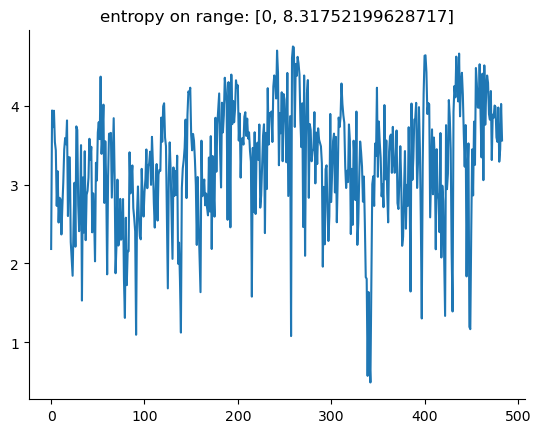

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.plot(entropies)
plt.title(f"entropy on range: [0, {np.log(posvec.shape[0])}]")
sns.despine()
plt.show()

<Axes: >

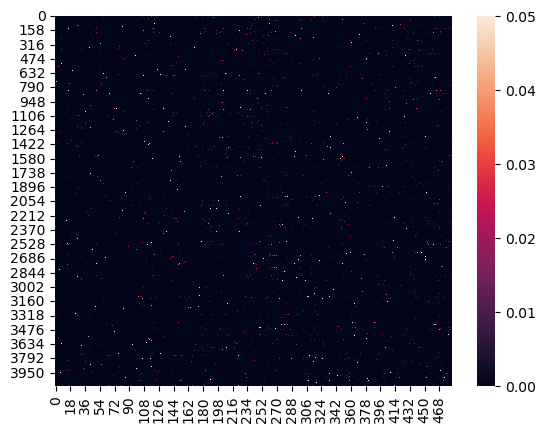

In [43]:
import seaborn as sns

sns.heatmap(posvec_norm,vmax=0.05)

In [14]:
# Generate a completion for a partial Carbonic Anhydrase (2vvb)
prompt = "___________________________________________________DQATSLRILNNGHAFNVEFDDSQDKAVLKGGPLDGTYRLIQFHFHWGSLDGQGSEHTVDKKKYAAELHLVHWNTKYGDFGKAVQQPDGLAVLGIFLKVGSAKPGLQKVVDVLDSIKTKGKSADFTNFDPRGLLPESLDYWTYPGSLTTPP___________________________________________________________"
protein = ESMProtein(sequence=prompt)
# Generate the sequence, then the structure. This will iteratively unmask the sequence track.
protein = model.generate(protein, GenerationConfig(track="sequence", num_steps=8, temperature=0.7))
# We can show the predicted structure for the generated sequence.
protein = model.generate(protein, GenerationConfig(track="structure", num_steps=8, temperature=0.7))
protein.to_pdb("./generation.pdb")
# Then we can do a round trip design by inverse folding the sequence and recomputing the structure
protein.sequence = None
protein = model.generate(protein, GenerationConfig(track="sequence", num_steps=8))
protein.coordinates = None
protein = model.generate(protein, GenerationConfig(track="structure", num_steps=8))
protein.to_pdb("./round_tripped.pdb")

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 33.49it/s]
/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/esm/utils/structure/protein_complex.py:223: UserWarning: Entity ID not found in metadata, using None as default
  warnings.warn("Entity ID not found in metadata, using None as default")
/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore
100%|██████████| 8/8 [00:00<00:00, 32.62it/s]


In [19]:
prompt2 = "DQATSLRILNNGHAFNVEFDDSQDKAVLKGGPLDGTYRLIQFHFHWGSLDGQGSEHTVDKKKYAAELHLVHWNTKYGDFGKAVQQPDGLAVLGIFLKVGSAKPGLQKVVDVLDSIKTKGKSADFTNFDPRGLLPESLDYWTYPGSLTTPP"
prompt3 = "DQATSLRILNNGHAFNVEFDDSQDKAVLKGGPLDGTYRLIQFHFHWGSLDGQGSEHTVDKKKYAAELHLVHWNTKYGDFGKAVQQPDGLAVLGIFLKVGSAKPGLQKVVDVLDSIKTKGKSADFTNFDPRGLLPESLDYWTYPGSLTTPP"
prompt4 = "DQATSLRILNNGHAFNVEFDDSQDKAVLKGGPLDGTYRLIQFHFHWGSLDGQGSEHTVDKKKYAAELHLVHWNTKYGDFGKAVQQPDGLAVLGIFLKVGSAKPGLQKVVDVLDSIKTKGKSADFTNFDPRGLLPESLDYWTYPGSLTTPP"
esmprots = [ESMProtein(sequence=i) for i in [prompt2, prompt3, prompt4]]
tokens = [model.encode(i) for i in esmprots]

In [13]:
from esm.sdk.api import LogitsConfig

In [22]:
sequence_lengths = [len(tokens) for tokens in tokens]
batched_tokens = _stack_protein_tensors(
        tokens,
        sequence_lengths,
        tokenizers,
        torch.device("cuda"),
    )

In [25]:
logits = model.logits(batched_tokens, LogitsConfig(
            sequence=True,
            structure=True,
            secondary_structure=False,
            sasa=False,
            function=False,
            residue_annotations=False,
            return_embeddings=True,
        ))

In [30]:
len(prompt2)

150

In [26]:
logits.logits.sequence.shape

torch.Size([3, 152, 64])

In [27]:
logits.embeddings.shape

torch.Size([3, 152, 1536])

In [28]:
logits.embeddings

tensor([[[  92.0000,  -11.5000,  -26.0000,  ...,  -36.7500,  -80.0000,
           -41.0000],
         [ 203.0000,  -28.2500,  -85.0000,  ..., -111.0000,  -38.5000,
            15.5000],
         [  33.0000, -139.0000,   92.5000,  ...,   -6.0000, -134.0000,
           -67.0000],
         ...,
         [-212.0000,   27.7500,   94.5000,  ...,  -47.7500,   99.0000,
           -88.0000],
         [-164.0000,   75.0000,   28.0000,  ..., -174.0000,  135.0000,
            69.5000],
         [ -90.5000,   82.0000,  165.0000,  ...,    6.0000,    6.0000,
          -107.0000]],

        [[  92.0000,  -11.5000,  -26.0000,  ...,  -36.7500,  -80.0000,
           -41.0000],
         [ 203.0000,  -28.2500,  -85.0000,  ..., -111.0000,  -38.5000,
            15.5000],
         [  33.0000, -139.0000,   92.5000,  ...,   -6.0000, -134.0000,
           -67.0000],
         ...,
         [-212.0000,   27.7500,   94.5000,  ...,  -47.7500,   99.0000,
           -88.0000],
         [-164.0000,   75.0000,   28.000